In [1]:
import sys
sys.path.append('../src')

from pipelines import preprocessing_pipeline
from pipelines import classifier_pipeline

import os
import math
import numpy as np
import random
from tqdm import tqdm 

import matplotlib.pyplot as plt

import cv2
from skimage import io, color, transform, feature
from skimage.feature import hog, local_binary_pattern

from sklearn.base import (
    BaseEstimator, 
    TransformerMixin
)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score, 
    classification_report,
    confusion_matrix
)
from sklearn.svm import SVC

root_path = '../'
ck_data_path = os.path.join(root_path, 'data/CK+48')
jaffe_data_path = os.path.join(root_path, 'data/JAFFE')

# Data

In [2]:
ck_images, ck_labels = preprocessing_pipeline(ck_data_path, 'ck', verbose=True)
jaffe_images, jaffe_labels = preprocessing_pipeline(jaffe_data_path, 'jaffe', verbose=True)

  0%|          | 0/981 [00:00<?, ?it/s]

100%|██████████| 981/981 [00:02<00:00, 405.96it/s]


Dataset: ck
Dataset length: 981
Image shape: (48, 48)


100%|██████████| 213/213 [00:00<00:00, 1195.83it/s]

Dataset: jaffe
Dataset length: 213
Image shape: (256, 256)


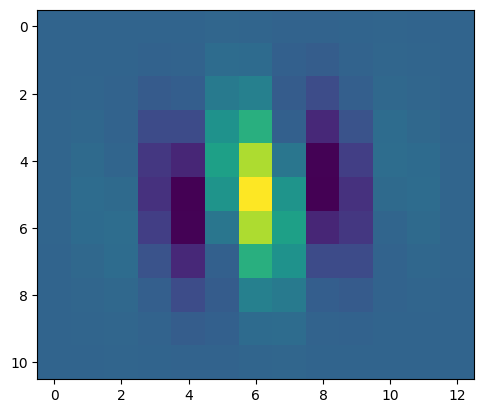

In [18]:
import numpy as np


def gabor(sigma, theta, Lambda, psi, gamma):
    """Gabor feature extraction."""
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    # Bounding box
    nstds = 3  # Number of standard deviation sigma
    xmax = max(
        abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta))
    )
    xmax = np.ceil(max(1, xmax))
    ymax = max(
        abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta))
    )
    ymax = np.ceil(max(1, ymax))
    xmin = -xmax
    ymin = -ymax
    (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))

    # Rotation
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gb = np.exp(
        -0.5 * (x_theta**2 / sigma_x**2 + y_theta**2 / sigma_y**2)
    ) * np.cos(2 * np.pi / Lambda * x_theta + psi)
    return gb

plt.imshow(gabor(2, 30, 5, 0, 1.2))

# Handmade Gabor Filters

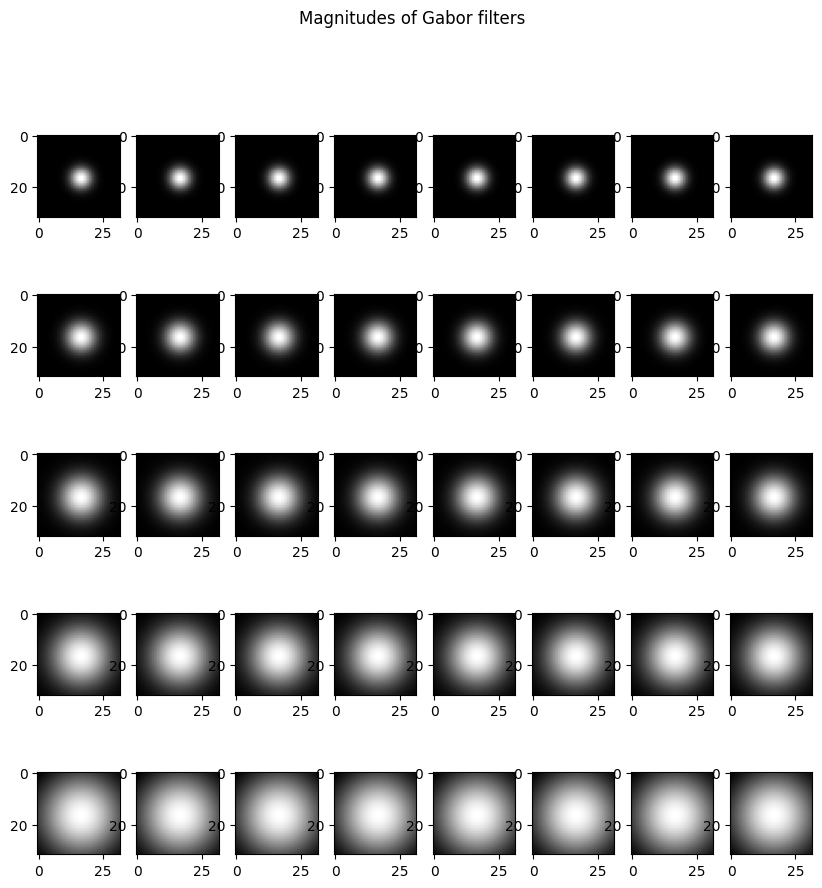

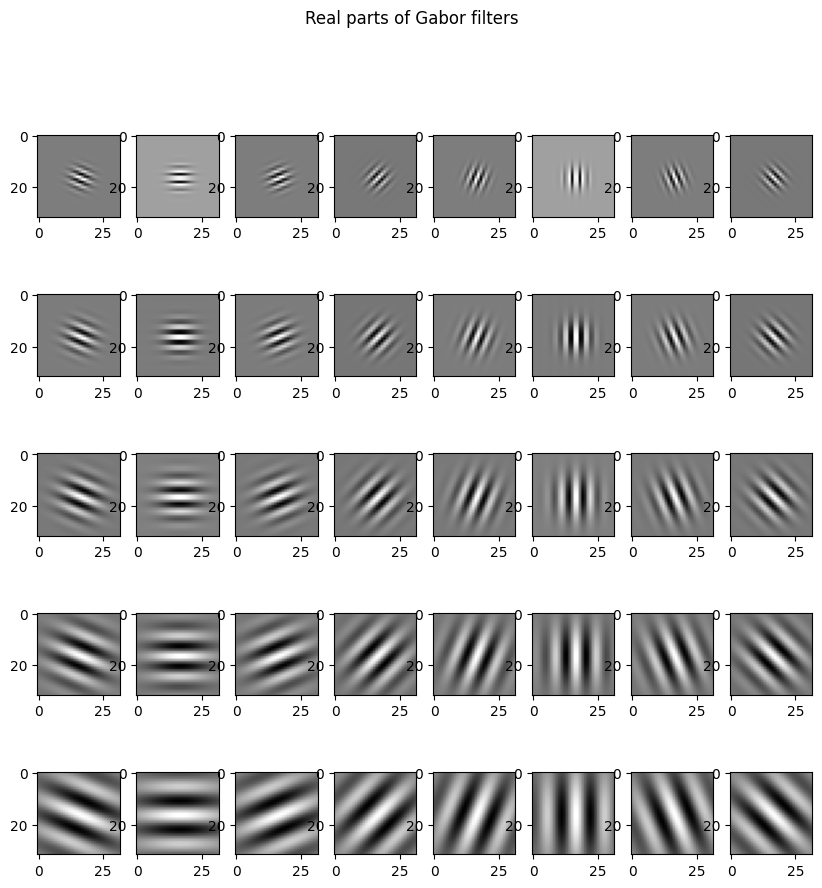

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def gaborFilterBank(u, v, m, n):
    if len([arg for arg in [u, v, m, n] if arg is not None]) != 4:
        raise ValueError('There must be four input arguments (Number of scales and orientations and the 2-D size of the filter)!')

    # Create Gabor filters
    gaborArray = [[None] * v for _ in range(u)]
    fmax = 0.25
    gama = np.sqrt(2)
    eta = np.sqrt(2)

    for i in range(u):
        fu = fmax / ((np.sqrt(2)) ** (i - 1))
        alpha = fu / gama
        beta = fu / eta

        for j in range(v):
            tetav = ((j - 1) / v) * np.pi
            gFilter = np.zeros((m, n), dtype=complex)

            for x in range(m):
                for y in range(n):
                    xprime = (x - ((m + 1) / 2)) * np.cos(tetav) + (y - ((n + 1) / 2)) * np.sin(tetav)
                    yprime = -(x - ((m + 1) / 2)) * np.sin(tetav) + (y - ((n + 1) / 2)) * np.cos(tetav)
                    gFilter[x, y] = (fu**2 / (np.pi * gama * eta)) * np.exp(-((alpha**2) * (xprime**2) + (beta**2) * (yprime**2))) * np.exp(1j * 2 * np.pi * fu * xprime)

            gaborArray[i][j] = gFilter

    # Show magnitudes of Gabor filters
    fig, axs = plt.subplots(u, v, figsize=(10, 10))
    for i in range(u):
        for j in range(v):
            axs[i, j].imshow(np.abs(gaborArray[i][j]), cmap='gray')
    plt.suptitle('Magnitudes of Gabor filters')
    plt.show()

    # Show real parts of Gabor filters
    fig, axs = plt.subplots(u, v, figsize=(10, 10))
    for i in range(u):
        for j in range(v):
            axs[i, j].imshow(np.real(gaborArray[i][j]), cmap='gray')
    plt.suptitle('Real parts of Gabor filters')
    plt.show()

    return gaborArray

# Sample use:
gaborArray = gaborFilterBank(5, 8, 32, 32)


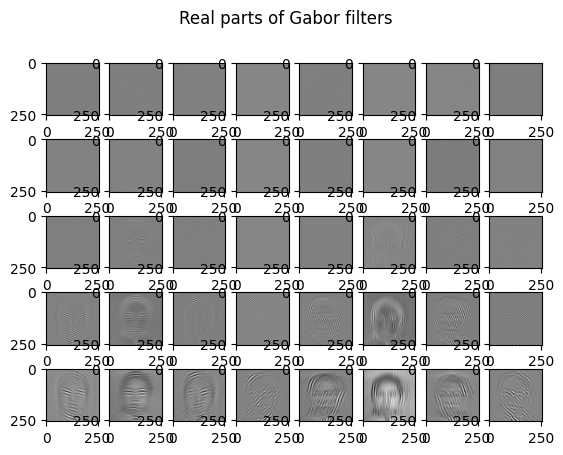

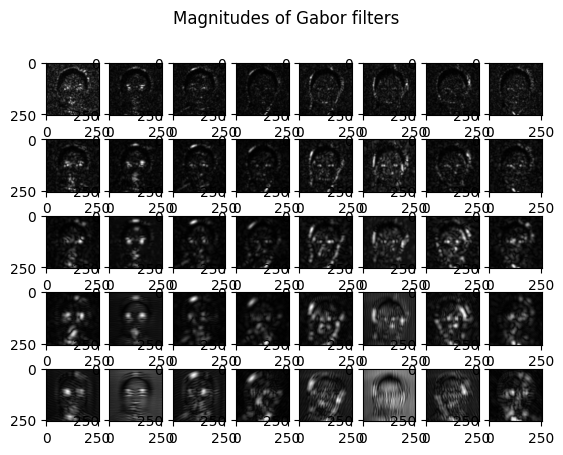

(163840,)


In [16]:

def gaborFeatures(img, gaborArray, d1, d2):
    if len([arg for arg in [img, gaborArray, d1, d2] if arg is not None]) != 4:
        raise ValueError('Please use the correct number of input arguments!')

    # if img.shape[2] == 3:
    #     print('The input RGB image is converted to grayscale!')
    #     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = img.astype(float)

    # Filter the image using the real and imaginary parts of the Gabor filter bank
    u, v = len(gaborArray), len(gaborArray[0])
    gaborResult = [[None] * v for _ in range(u)]

    for i in range(u):
        for j in range(v):
            real_part = cv2.filter2D(img, cv2.CV_64F, np.real(gaborArray[i][j]))
            imag_part = cv2.filter2D(img, cv2.CV_64F, np.imag(gaborArray[i][j]))
            gaborResult[i][j] = real_part + 1j * imag_part

    # Create feature vector
    featureVector = np.array([])
    for i in range(u):
        for j in range(v):
            gaborAbs = np.abs(gaborResult[i][j])
            gaborAbs = gaborAbs[::d1, ::d2].flatten()

            # Normalized to zero mean and unit variance
            gaborAbs = (gaborAbs - np.mean(gaborAbs)) / np.std(gaborAbs, ddof=1)
            featureVector = np.concatenate((featureVector, gaborAbs))

    # Show filtered images (uncomment if needed)
    for i in range(u):
        for j in range(v):
            plt.subplot(u, v, i * v + j + 1)
            plt.imshow(np.real(gaborResult[i][j]), cmap='gray')
    plt.suptitle('Real parts of Gabor filters')
    plt.show()

    for i in range(u):
        for j in range(v):
            plt.subplot(u, v, i * v + j + 1)
            plt.imshow(np.abs(gaborResult[i][j]), cmap='gray')
    plt.suptitle('Magnitudes of Gabor filters')
    plt.show()

    return featureVector

# Sample use:
img = jaffe_images[0]
featureVector = gaborFeatures(img, gaborArray, 4, 4)
print(featureVector.shape)

18
(15, 15)


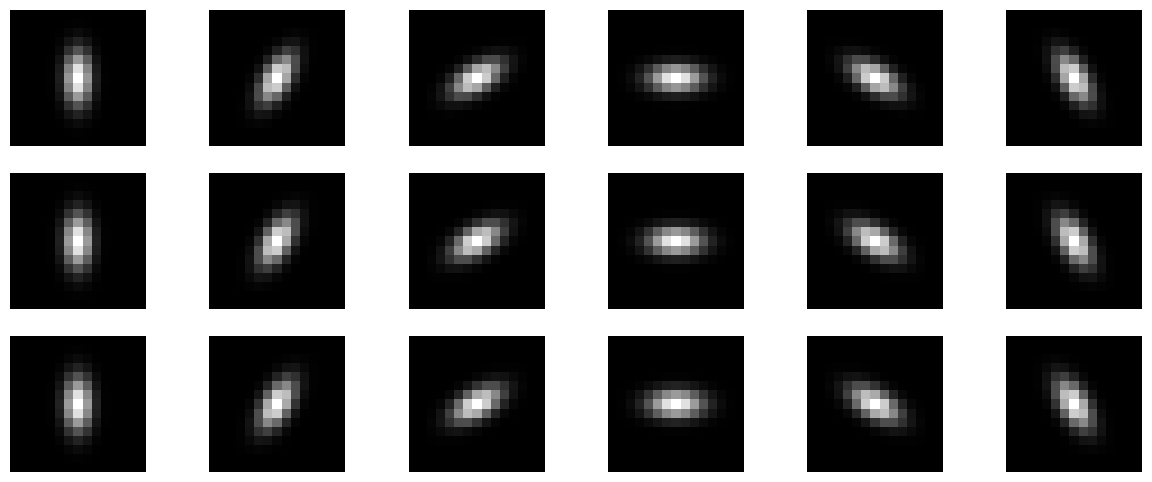

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def create_gabor_filter(size, sigma, theta, lambd, gamma):
    """Create a Gabor filter kernel."""
    radius = (size - 1) // 2
    x, y = np.meshgrid(np.arange(-radius, radius + 1), np.arange(-radius, radius + 1))
    
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)
    
    gabor_filter = np.exp(-(x_theta**2 + (gamma**2 * y_theta**2)) / (2 * sigma**2)) * np.cos(2 * np.pi * x_theta / lambd)
    
    return gabor_filter

def generate_gabor_filters(
    resolution, spatial_frequencies, orientations,
    sigma, gamma
):
    filters = []
    for freq in spatial_frequencies:
        for theta in orientations:
            theta_rad = np.radians(theta)
            gabor_filter = create_gabor_filter(resolution, sigma=1.0, theta=theta_rad, lambd=2*np.pi/freq, gamma=0.5)
            filters.append(gabor_filter)
    return filters

def plot_gabor_filters(filters, num_cols=6):
    num_filters = len(filters)
    num_rows = num_filters // num_cols + (1 if num_filters % num_cols != 0 else 0)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 2 * num_rows))

    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            ax.imshow(filters[i], cmap='gray', interpolation='nearest')
            ax.axis('off')
        else:
            ax.axis('off')

# kernel size
kernel_size = 16

# spatial frequencies
k = [1/4, 1/8, 1/16]

# Orientations in steps of 30 degrees from 0 to 180 degrees
orientations = [0,30,60,90,120,150]

# Generate Gabor filters
gabor_filters = generate_gabor_filters(
    kernel_size,
    spatial_frequencies, orientations,
    sigma = math.pi,
    gamma=0.5
)
print(len(gabor_filters))
print(gabor_filters[0].shape)

# Plot the Gabor filters
plot_gabor_filters(gabor_filters)
plt.savefig('figures/gabor-filters.png')
plt.show()


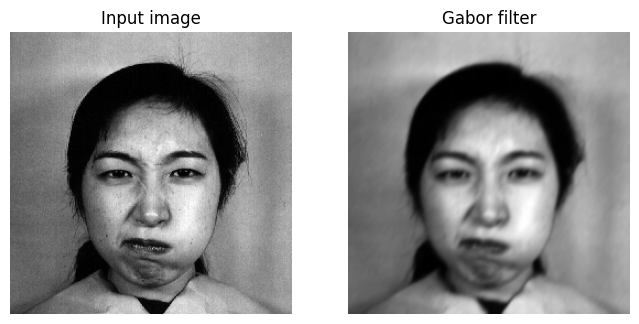

In [69]:
from scipy.signal import convolve2d


image = jaffe_images[0]
gabor_image = convolve2d(image, gabor_filters[1], mode='same', boundary='symm')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(image, cmap='gray')
ax1.set_title('Input image')
ax2.axis('off')
ax2.imshow(gabor_image, cmap='gray')
ax2.set_title('Gabor filter')
plt.savefig('figures/ck-gabor-filter.png')
plt.show()

In [72]:
def gabor_filter(kernel_size, sigma, gamma, lmbda, psi, angle):
    # get half size
    d = kernel_size // 2

    # prepare kernel
    gabor = np.zeros((kernel_size, kernel_size), dtype=np.float32)

    # each value
    for y in range(kernel_size):
        for x in range(kernel_size):
            # distance from center
            px = x - d
            py = y - d

            # degree -> radian
            theta = angle / 180. * np.pi

            # kernel x
            _x = np.cos(theta) * px + np.sin(theta) * py

            # kernel y
            _y = -np.sin(theta) * px + np.cos(theta) * py

            # fill kernel
            gabor[y, x] = np.exp(-(_x**2 + gamma**2 * _y**2) / (2 * sigma**2)) * np.cos(2*np.pi*_x/lmbda + psi)

    # kernel normalization
    gabor /= np.sum(np.abs(gabor))

    return gabor

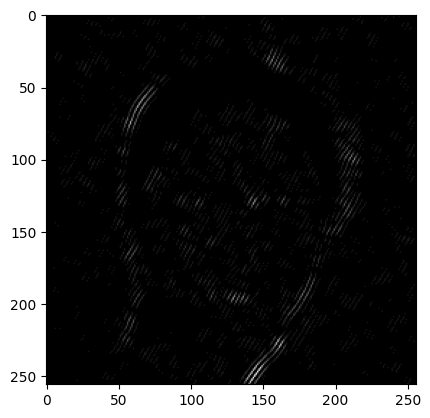

In [73]:
def gabor_filtering(image, kernel_size, sigma, gamma, lmbda, psi, angle):
    # get shape
    H, W = image.shape

    # padding
    image = np.pad(image, (kernel_size//2, kernel_size//2), 'edge')

    # prepare out image
    out = np.zeros((H, W), dtype=np.float32)

    # get gabor filter
    gabor = gabor_filter(
        kernel_size=kernel_size, 
        sigma=sigma, 
        gamma=gamma, 
        lmbda=lmbda,
        psi=psi, 
        angle=angle
    )

    # filtering
    for y in range(H):
        for x in range(W):
            out[y, x] = np.sum(image[y : y + kernel_size, x : x + kernel_size] * gabor)

    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)

    return out

gabor_jaffe_image = gabor_filtering(
    jaffe_images[0],
    # kernel_size=11,
    # sigma = 3,
    # gamma = 3, 
    # lmbda = 5,
    # psi=0,
    kernel_size=16,
    sigma=math.pi,
    gamma=1.2, 
    lmbda=3,
    psi=0,
    angle = 30 # [0,30,60,90,120,150]
    )

k = [math.pi/4, math.pi/8, math.pi/16]

plt.imshow(gabor_jaffe_image, cmap='gray')
plt.show()

# gabor_ck_image = gabor_filtering(
#     ck_images[0],
#     kernel_size=16,
#     sigma=1.5,
#     gamma=1.2, 
#     lmbda=3,
#     psi=0,
#     angle=30 # [0,30,60,90,120,150]
#     )

# plt.imshow(gabor_ck_image, cmap='gray')
# plt.show()


In [74]:
# Use 6 Gabor filters with different angles to perform feature extraction on the image
def gabor_process(
    image, 
    kernel_size=11,
    sigma=1.5,
    gamma=1.2, 
    lmbda=3,
    psi=0,
    angles = [0,30,60,90,120,150]
):
    
    H, W = image.shape
    out = np.zeros([H, W], dtype=np.float32)

    # each angle
    for i, angle in enumerate(angles):
    
        # gabor filtering
        _out = gabor_filtering(
            image, 
            kernel_size=kernel_size, 
            sigma=sigma, 
            gamma=gamma, 
            lmbda=lmbda, 
            psi=psi, 
            angle=angle
        )
         
        # add gabor filtered image
        out += _out
        
    # scale normalization
    out = out /out.max()*255
    out = out.astype(np.uint8)

    return out

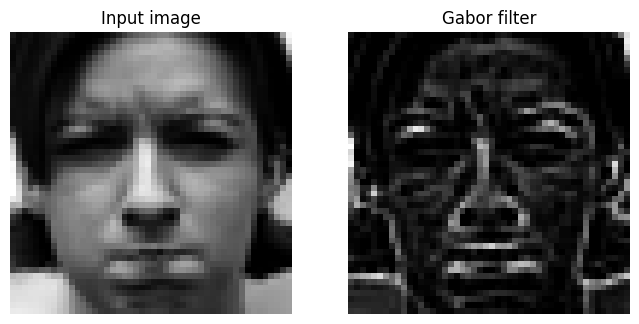

In [75]:
image = ck_images[0]
gabor_image = gabor_process(image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(image, cmap='gray')
ax1.set_title('Input image')
ax2.axis('off')
ax2.imshow(gabor_image, cmap='gray')
ax2.set_title('Gabor filter')
plt.savefig('figures/ck-gabor-filter.png')
plt.show()

# With cv2

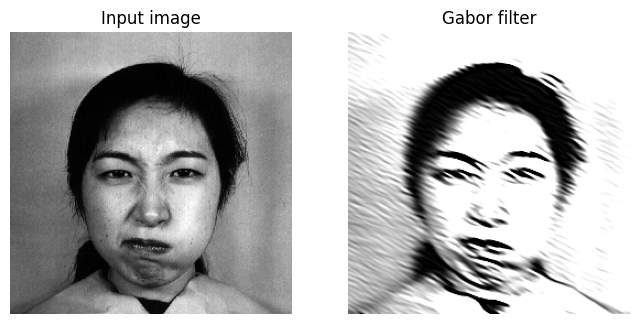

In [85]:
import cv2
# Function to extract Gabor features from an image
def gabor_features(image, ksize=9, sigma=2.0, theta=0, lambd=5.0, gamma=0.5):
    gabor_filter = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, 0, ktype=cv2.CV_64F)
    filtered_image = cv2.filter2D(image, cv2.CV_8UC3, gabor_filter)
    # return filtered_image.flatten()
    return filtered_image

image = jaffe_images[0]
gabor_image = gabor_features(image, ksize=16, sigma=2, theta=90)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(image, cmap='gray')
ax1.set_title('Input image')
ax2.axis('off')
ax2.imshow(gabor_image, cmap='gray')
ax2.set_title('Gabor filter')
plt.show()


# Gabor pipeline

In [87]:
from pipelines import gabor_pipeline

gabor_features = gabor_pipeline(
    ck_images,
    kernel_size=11,
    sigma=1.5,
    gamma=1.2, 
    lmbda=3,
    psi=0,
    angles = [0,30,60,90,120,150],  
    verbose=True)
gabor_features.shape

X = gabor_features
y = ck_labels 

train_results, test_results = classifier_pipeline(X, y, verbose=True)

100%|██████████| 981/981 [04:22<00:00,  3.74it/s]


kernel size: 11
sigma: 1.5
gamma: 1.2
lambda: 3
angles: [0, 30, 60, 90, 120, 150]
Features: (981, 2304)
Train Result:
Accuracy Score: 100.00%
Test Result:
Accuracy Score: 99.66%


In [85]:
from pipelines import gabor_pipeline

gabor_features = gabor_pipeline(jaffe_images, resize=(32,32))
gabor_features.shape

X = gabor_features
y = jaffe_labels 

train_results, test_results = classifier_pipeline(X, y, verbose=True)

100%|██████████| 213/213 [00:08<00:00, 25.58it/s]

Train Result:
Accuracy Score: 100.00%
Test Result:
Accuracy Score: 78.12%


# Gridsearch

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    *preprocessing_pipeline(jaffe_data_path, 'jaffe'),
    test_size=0.25, random_state=42, shuffle=True
)

gabor_sk_pipeline = Pipeline([
    ('gabor_features', GaborTransformer()),
    ('svc', SVC(kernel='rbf', gamma='scale', C= 10))
])

param_grid = {
    'gabor_features__kernel_size': [7, 9, 11],
    'gabor_features__sigma': [0.5, 1.5, 3], # Size of the Filter (σ)
    'gabor_features__gamma': [0.5, 1.2, 3], # Aspect Ratio (γ)
    'gabor_features__lmbda': [1, 5, 10], # Spatial Frequency (λ)
    'gabor_features__psi': [0],
    'gabor_features__angles': [[0,30,60,90,120,150], [0, 45, 90, 135]] # Orientation (θ)
}

grid_search = GridSearchCV(
    estimator=gabor_sk_pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=4,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print("Best parameters found by grid search:")
print(best_params)


y_train_pred = best_estimator.predict(X_train)
print("\nTest Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(y_train, y_train_pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{classification_report(y_train, y_train_pred)}")
print("_______________________________________________")
print(f"Confusion Matrix: \n{confusion_matrix(y_train, y_train_pred)}")


y_test_pred = best_estimator.predict(X_test)
print("\nTest Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(y_test, y_test_pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{classification_report(y_test, y_test_pred)}")
print("_______________________________________________")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_test_pred)}")

# Best parameters found by grid search:
# {'gabor_features__angles': [0, 30, 60, 90, 120, 150], 'gabor_features__gamma': 3, 'gabor_features__kernel_size': 11, 'gabor_features__lmbda': 5, 'gabor_features__psi': 0, 'gabor_features__sigma': 3}
# 100%|██████████| 159/159 [00:06<00:00, 23.26it/s]

# Test Result:
# ================================================
# Accuracy Score: 99.37%
# _______________________________________________
# CLASSIFICATION REPORT:
#               precision    recall  f1-score   support

#        Anger       1.00      1.00      1.00        21
#      Disgust       1.00      1.00      1.00        25
#         Fear       1.00      1.00      1.00        22
#    Happiness       0.96      1.00      0.98        23
#      Neutral       1.00      1.00      1.00        21
#      Sadness       1.00      0.96      0.98        26
#     Surprise       1.00      1.00      1.00        21

#     accuracy                           0.99       159
#    macro avg       0.99      0.99      0.99       159
# weighted avg       0.99      0.99      0.99       159

# _______________________________________________
# Confusion Matrix: 
# [[21  0  0  0  0  0  0]
#  [ 0 25  0  0  0  0  0]
#  [ 0  0 22  0  0  0  0]
#  [ 0  0  0 23  0  0  0]
#  [ 0  0  0  0 21  0  0]
#  [ 0  0  0  1  0 25  0]
#  [ 0  0  0  0  0  0 21]]
# 100%|██████████| 54/54 [00:02<00:00, 24.08it/s]

# Test Result:
# ================================================
# Accuracy Score: 87.04%
# _______________________________________________
# CLASSIFICATION REPORT:
#               precision    recall  f1-score   support

#        Anger       1.00      0.89      0.94         9
#      Disgust       0.60      0.75      0.67         4
#         Fear       0.88      0.70      0.78        10
#    Happiness       1.00      0.88      0.93         8
#      Neutral       0.82      1.00      0.90         9
#      Sadness       0.83      1.00      0.91         5
#     Surprise       0.89      0.89      0.89         9

#     accuracy                           0.87        54
#    macro avg       0.86      0.87      0.86        54
# weighted avg       0.88      0.87      0.87        54

# _______________________________________________
# Confusion Matrix: 
# [[8 0 1 0 0 0 0]
#  [0 3 0 0 0 1 0]
#  [0 2 7 0 0 0 1]
#  [0 0 0 7 1 0 0]
#  [0 0 0 0 9 0 0]
#  [0 0 0 0 0 5 0]
#  [0 0 0 0 1 0 8]]


In [5]:
from pipelines import full_gabor_pipeline

train_results, test_results = full_gabor_pipeline(
    ck_data_path, 
    'ck',
    kernel_size=11,
    sigma=1.5,
    gamma=1.2, 
    lmbda=3,
    psi=0,
    angles = [0,30,60,90,120,150],  
    resize = None,
    test_size = 0.3,
    random_state = 42,
    shuffle=True,
    verbose=True
)

# --- PREPROCESSING ---
#   0%|          | 0/981 [00:00<?, ?it/s]
# 100%|██████████| 981/981 [00:03<00:00, 261.38it/s]
# Dataset: ck
# Dataset length: 981
# Image shape: (48, 48)
# --- GABOR ---
# 100%|██████████| 981/981 [06:52<00:00,  2.38it/s]
# kernel size: 11
# sigma: 1.5
# gamma: 1.2
# lambda: 3
# angles: [0, 30, 60, 90, 120, 150]
# Features: (981, 2304)
# --- CLASSIF ---
# ================================================
# Train Result:
# Accuracy Score: 100.00%
# ================================================
# Test Result:
# Accuracy Score: 99.66%

--- PREPROCESSING ---


  0%|          | 0/981 [00:00<?, ?it/s]

100%|██████████| 981/981 [00:03<00:00, 261.38it/s]


Dataset: ck
Dataset length: 981
Image shape: (48, 48)
--- GABOR ---


100%|██████████| 981/981 [06:52<00:00,  2.38it/s]


kernel size: 11
sigma: 1.5
gamma: 1.2
lambda: 3
angles: [0, 30, 60, 90, 120, 150]
Features: (981, 2304)
--- CLASSIF ---
Train Result:
Accuracy Score: 100.00%
Test Result:
Accuracy Score: 99.66%


In [2]:
from pipelines import full_gabor_pipeline

train_results, test_results = full_gabor_pipeline(
    jaffe_data_path, 
    'jaffe',
    kernel_size=11,
    sigma=3,
    gamma=3, 
    lmbda=5,
    psi=0,
    angles = [0,30,60,90,120,150], 
    resize = (32,32),
    test_size = 0.3,
    random_state = 42,
    shuffle=True,
    verbose=True
)

# --- PREPROCESSING ---
# 100%|██████████| 213/213 [00:00<00:00, 976.94it/s]
# Dataset: jaffe
# Dataset length: 213
# Image shape: (256, 256)
# --- GABOR ---
# 100%|██████████| 213/213 [00:44<00:00,  4.84it/s]
# resize: (32, 32)
# kernel size: 11
# sigma: 3
# gamma: 3
# lambda: 5
# angles: [0, 30, 60, 90, 120, 150]
# Features: (213, 1024)
# --- CLASSIF ---
# ================================================
# Train Result:
# Accuracy Score: 99.33%
# ================================================
# Test Result:
# Accuracy Score: 82.81%

--- PREPROCESSING ---


100%|██████████| 213/213 [00:00<00:00, 976.94it/s]


Dataset: jaffe
Dataset length: 213
Image shape: (256, 256)
--- GABOR ---


100%|██████████| 213/213 [00:44<00:00,  4.84it/s]

resize: (32, 32)
kernel size: 11
sigma: 3
gamma: 3
lambda: 5
angles: [0, 30, 60, 90, 120, 150]
Features: (213, 1024)
--- CLASSIF ---
Train Result:
Accuracy Score: 99.33%
Test Result:
Accuracy Score: 82.81%


# cross-val

In [4]:
from pipelines import GaborTransformer

ck_images, ck_labels = preprocessing_pipeline(ck_data_path, 'ck')

cv = KFold(n_splits=4, random_state=42, shuffle=True)

gabor_sk_pipeline = Pipeline([
    (
        'gabor_features', GaborTransformer(
            kernel_size=11,
            sigma=1.5,
            gamma=1.2, 
            lmbda=3,
            psi=0,
            angles = [0,30,60,90,120,150],  
            resize = None
        )
    ),
    ('svc', SVC(kernel='rbf', gamma='scale', C= 10))
])

scores = cross_val_score(gabor_sk_pipeline, ck_images, ck_labels, scoring='accuracy', cv=cv, n_jobs=-1)
print('SVM MEAN  Accuracy: ',str(np.mean(scores)*100)[:5] + '%')
print('Standard deviation: ',str(np.std(scores)*100)[:5] + '%')

# 100%|██████████| 213/213 [00:00<00:00, 985.37it/s] 
# SVM MEAN  Accuracy:  82.13%
# Standard deviation:  3.221%


  0%|          | 0/981 [00:00<?, ?it/s]

100%|██████████| 981/981 [00:03<00:00, 262.25it/s]


SVM MEAN  Accuracy:  98.36%
Standard deviation:  1.290%


In [88]:
from pipelines import GaborTransformer

jaffe_images, jaffe_labels = preprocessing_pipeline(jaffe_data_path, 'jaffe')

cv = KFold(n_splits=4, random_state=42, shuffle=True)

gabor_sk_pipeline = Pipeline([
    (
        'gabor_features', GaborTransformer(
            kernel_size=11,
            sigma=3,
            gamma=3, 
            lmbda=5,
            psi=0,
            angles = [0,30,60,90,120,150], 
            resize = (32,32))
    ),
    ('svc', SVC(kernel='rbf', gamma='scale', C= 10))
])

scores = cross_val_score(gabor_sk_pipeline, jaffe_images, jaffe_labels, scoring='accuracy', cv=cv, n_jobs=-1)
print('SVM MEAN  Accuracy: ',str(np.mean(scores)*100)[:5] + '%')
print('Standard deviation: ',str(np.std(scores)*100)[:5] + '%')

# 100%|██████████| 213/213 [00:00<00:00, 985.37it/s] 
# SVM MEAN  Accuracy:  82.13%
# Standard deviation:  3.221%

100%|██████████| 213/213 [00:00<00:00, 1192.73it/s]


SVM MEAN  Accuracy:  82.13%
Standard deviation:  3.964%
